In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

%load_ext autoreload

In [3]:
DATA_PATH = "./data/aligned_data/"

In [4]:
with open("./data/aligned_ticker_1878.json") as jsf:
    new_tickers = json.load(jsf)

In [5]:
prices = pd.read_csv(f"{DATA_PATH}/prices.csv", parse_dates=True, index_col=0)
returns = pd.read_csv(f"{DATA_PATH}/returns.csv", parse_dates=True, index_col=0)
volume = pd.read_csv(f"{DATA_PATH}/volume.csv", parse_dates=True, index_col=0)
ychopmdf = pd.read_csv(f"{DATA_PATH}/ychopmdf.csv", parse_dates=True, index_col=0) / 100
asset_turnover = pd.read_csv(f"{DATA_PATH}/asset_turnover.csv", parse_dates=True, index_col=0)
benchmark_prices = pd.read_csv(f"{DATA_PATH}/benchmark_sp500.csv", parse_dates=True, index_col=0)

company_info = pd.read_csv("./data/yf/company_info.csv")

In [6]:
benchmark = (1 + benchmark_prices.pct_change()).apply(np.log).iloc[1:]
benchmark.T

Date,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01,2023-04-01
adj_close,0.247869,0.030955,0.164849,0.199141,0.051153,0.01718,0.143781,0.114857,0.078976,0.052488,0.326538,-0.126887,0.085697


To compose portfolios with lowest Operating Margin and highest Asset Turnover we need a way to select best candidates. To this end, I will constuct a matrix with the difference of normalized Asset Turnover and Operating Margin.

In [7]:
def min_max_scale(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function performs min-max scaling on a pandas DataFrame.
    Min-max scaling transforms the numerical values in each column of the DataFrame to a range between 0 and 1, where the minimum value becomes 0 and the maximum value becomes 1. 

    Returns: A pandas DataFrame with the same shape and columns as the input, but with scaled values between 0 and 1.
    """
    df = (df - df.min()) / (df.max() - df.min())
    return df.copy()

In [8]:
asset_turnover.T.describe()

date,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01,2023-04-01
count,1305.000000,1370.000000,1439.000000,1429.000000,1435.000000,1432.000000,1418.000000,1426.000000,1435.000000,1428.000000,1431.000000,1406.000000,1422.000000
mean,1.010640,1.036952,1.019370,0.999019,0.982535,0.927663,0.906086,0.894694,0.899375,0.863448,0.775266,0.809848,0.886950
std,0.924548,0.937170,0.926441,0.922335,0.898722,0.812468,0.762356,0.750489,0.757387,0.719789,0.650543,0.694917,0.774880
min,0.012465,0.013403,-0.242140,0.011240,0.012108,0.009632,0.009705,0.011975,-0.055927,0.014530,0.006633,-1.900920,-0.785907
25%,0.458644,0.463316,0.457041,0.439247,0.444430,0.406542,0.408310,0.396130,0.396954,0.387464,0.350576,0.383198,0.415301
50%,0.795539,0.842319,0.809636,0.788305,0.763038,0.726132,0.725221,0.726637,0.727441,0.689295,0.624593,0.670920,0.725911
75%,1.275752,1.323878,1.312991,1.282075,1.250650,1.211298,1.198630,1.180717,1.197453,1.130541,1.002793,1.035381,1.122223
max,11.221488,11.055405,11.010551,11.414836,11.504301,11.203356,11.212121,10.510263,9.729531,9.352953,8.799283,8.883930,8.873837


<Axes: >

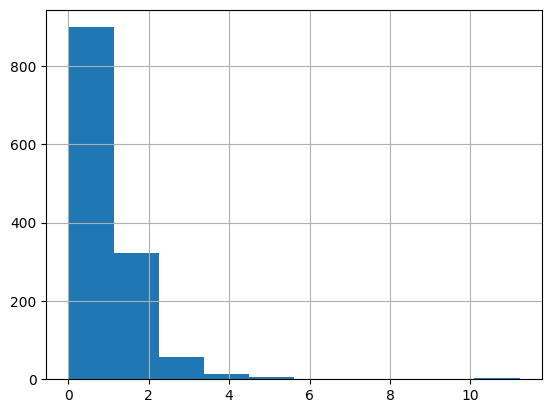

In [9]:
asset_turnover.T["2011-04-01"].hist()

In [10]:
asset_turnover.isna().sum().sort_values()

A        0
KMTUY    0
KMT      0
KMB      0
KLIC     0
        ..
PCTI     3
NLS      3
EHTH     3
AXON     3
LPX      3
Length: 1440, dtype: int64

In [11]:
diff_vector = (min_max_scale(asset_turnover.T) - min_max_scale(ychopmdf.T)).T

In [12]:
diff_vector.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-04-01 to 2023-04-01
Columns: 1440 entries, A to SEKEY
dtypes: float64(1440)
memory usage: 146.9 KB


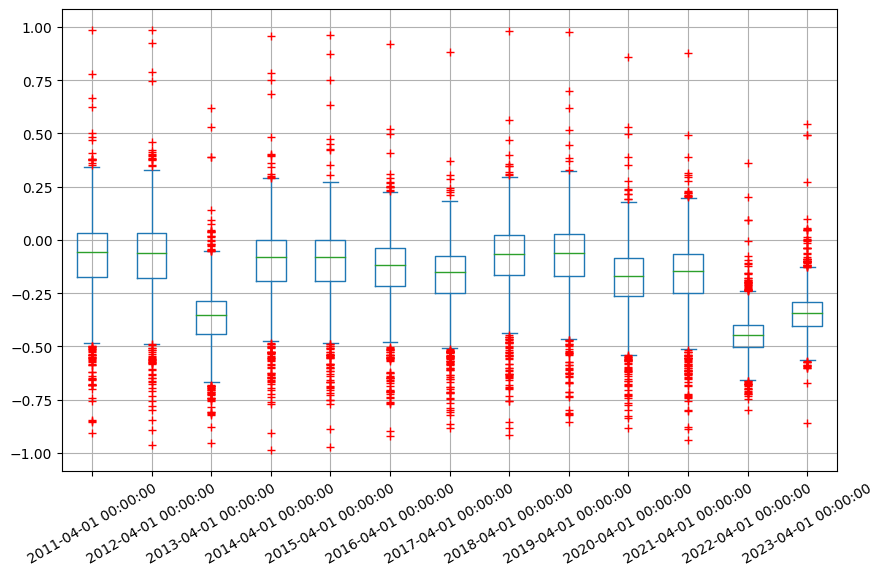

In [13]:
diff_vector.T.plot(kind="box", figsize=(10,6), rot=30, grid=True, sym="r+")
# plt.title("Boxplot (Ящик с усами) для diff_vector")
plt.show()

In [37]:
diff_vector.index

DatetimeIndex(['2011-04-01', '2012-04-01', '2013-04-01', '2014-04-01',
               '2015-04-01', '2016-04-01', '2017-04-01', '2018-04-01',
               '2019-04-01', '2020-04-01', '2021-04-01', '2022-04-01',
               '2023-04-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [50]:
%autoreload 2
from strategies import PortfolioType, Universe, Portfolio, Strategy  # noqa: F401


In [52]:
universe = Universe(diff_vector, ychopmdf, asset_turnover, returns, volume, company_info)
strategy = Strategy()
strategy.construct_portfolios(universe, pd.DateOffset(years=1))

  8%|▊         | 1/12 [00:00<00:02,  5.10it/s]

data_df_for_candidates=DIT    0.923551
INT    0.985768
AE     0.787508
EC    -0.232538
GLP    0.745969
ABC    0.461895
Name: 2012-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=DIT    False
INT    False
AE     False
EC     False
GLP    False
ABC    False
Name: 2012-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=DIT    0.014850
INT    0.007975
AE     0.014225
EC     0.298925
GLP    0.004000
ABC    0.015200
Name: 2012-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=DIT    False
INT    False
AE     False
EC     False
GLP    False
ABC    False
Name: 2012-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=DIT    10.445592
INT    11.055405
AE      8.936395
EC      0.869534
GLP     8.362919
ABC     5.351921
Name: 2012-04-01 00:00:00, dtype: float64
type(data_df_for_candid

100%|██████████| 12/12 [00:01<00:00,  8.55it/s]

data_df_for_candidates=DIT    0.921798
AE     0.520334
INT    0.499115
GLP    0.310639
ABC    0.410157
MHH    0.271561
Name: 2016-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=DIT    False
AE     False
INT    False
GLP    False
ABC    False
MHH    False
Name: 2016-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=DIT    0.008650
AE     0.003850
INT    0.007525
GLP    0.011375
ABC    0.010325
MHH    0.035725
Name: 2016-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=DIT    False
AE     False
INT    False
GLP    False
ABC    False
MHH    False
Name: 2016-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=DIT    11.203356
AE      6.657192
INT     6.459707
GLP     4.391906
ABC     5.494443
MHH     4.219754
Name: 2016-04-01 00:00:00, dtype: float64
type(data_df_for_candid

In [43]:
pd.Timestamp(year=2011, month=4, day=1)

Timestamp('2011-04-01 00:00:00')

In [44]:
universe.verify_candidates(["A", "ABB"], pd.Timestamp(year=2011, month=4, day=1))

data_df_for_candidates=A     -0.050734
ABB   -0.045263
Name: 2011-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=A      False
ABB    False
Name: 2011-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=A      0.1040
ABB    0.1213
Name: 2011-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=A      False
ABB    False
Name: 2011-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=A      0.629073
ABB    0.889483
Name: 2011-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pandas.core.series.Series'>
count_nas=A      False
ABB    False
Name: 2011-04-01 00:00:00, dtype: bool
type(count_nas)=<class 'pandas.core.series.Series'>
data_df_for_candidates=A      0.586536
ABB    0.432402
Name: 2011-04-01 00:00:00, dtype: float64
type(data_df_for_candidates)=<class 'pan

[]

In [45]:
# strategy.portfolios['2011-04-01'][0].info

atest_df = pd.concat([port[0].info for port in strategy.portfolios.values()]) # type: ignore

In [46]:
loht_returns = []
holt_returns = []
difference = []

for loht, holt in strategy.portfolios.values():
    loht_returns.append(loht.mean_return)
    holt_returns.append(holt.mean_return)
    difference.append(loht.mean_return - holt.mean_return) # type: ignore

In [47]:
np.mean(loht_returns), np.mean(holt_returns)

(0.05871381676251556, -0.045950115816058325)

In [48]:
results_df = pd.DataFrame([loht_returns, holt_returns, benchmark.values.flatten()[:-1]])
results_df.columns = [date.strftime("%Y-%m-%d") for date in diff_vector.index[:-1]]
results_df = results_df.set_index(
    pd.Index(
        [
            "LOHT",
            "HOLT",
            "S&P 500",
        ],
        name=None,
    )
)
results_df

,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01
LOHT,0.099557,0.380308,0.183221,-0.147656,-0.224350,0.130716,0.117688,0.092883,-0.385748,0.316810,0.094658,0.046479
HOLT,-0.158522,-0.064528,0.127379,-0.331456,0.026348,0.106864,0.260619,0.179605,-0.585292,0.414101,-0.227851,-0.298668
S&P 500,0.247869,0.030955,0.164849,0.199141,0.051153,0.017180,0.143781,0.114857,0.078976,0.052488,0.326538,-0.126887


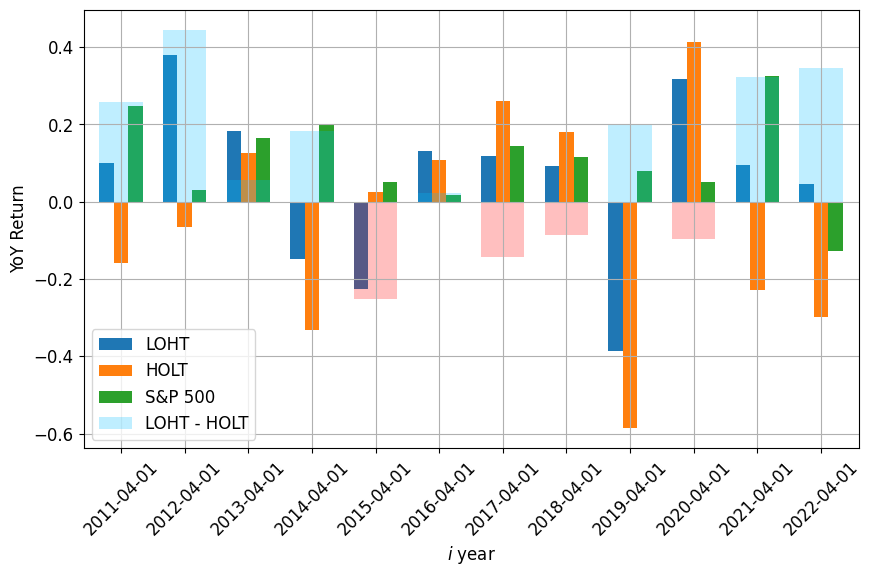

In [49]:
plt.rcParams["font.size"] = "12"

results_df.T.plot(
    kind="bar",
    figsize=(10, 6),
    xlabel=r"$i$ year",
    ylabel="YoY Return",
    width=0.68,
)

(results_df.iloc[0] - results_df.iloc[1]).plot(
    kind="bar",
    secondary_y=False,
    color=np.where((results_df.iloc[0] - results_df.iloc[1]) < 0, "red", "deepskyblue"),
    grid=True,
    label="LOHT - HOLT",
    alpha=0.25,
    width=0.68,
)

plt.legend(loc="lower left")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)